In [2]:
import uproot as up
import numpy as np
import time
import iminuit
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
import matplotlib.pyplot as plt
import sys
import tensorflow as tf
from multiprocessing import Pool
import multiprocessing


sys.path.append('/software/pc24403/tfpcbpggsz/amp_ampgen_test')
from D0ToKSpipi2018 import *

Kspipi = PyD0ToKSpipi2018()
Kspipi.init()
print('INFO: Loading the amplitude model')
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="1"

INFO: Loading the amplitude modelD0ToKSpipi2018 (Apr 30 2024) ==> Initialization !



In [3]:
def get_mass(p1,p2):
    return ((p1[:,0]+p2[:,0])**2 - (p1[:,1]+p2[:,1])**2 - (p1[:,2]+p2[:,2])**2 - (p1[:,3]+p2[:,3])**2)


def load_int_amp(args):
    p1, p2, p3 = args

    return Kspipi.AMP(p1.tolist(), p2.tolist(), p3.tolist())

def getAmp(decay='b2dpi', cut='int'):

    start_time = time.time()
    p1, p2, p3, p1bar, p2bar, p3bar = get_p4(decay=decay, cut=cut)
    amplitude = []
    amplitudeBar = []

    p1_np = np.array(p1)
    p2_np = np.array(p2)
    p3_np = np.array(p3)
    p1bar_np = np.array(p1bar)
    p2bar_np = np.array(p2bar)
    p3bar_np = np.array(p3bar)

    data = [(p1_np[i], p2_np[i], p3_np[i]) for i in range(len(p1_np))]
    with Pool(processes=multiprocessing.cpu_count()) as pool:
        amplitude.append(pool.map(load_int_amp, data))
    data_bar = [(p1bar_np[i], p3bar_np[i], p2bar_np[i]) for i in range(len(p1bar_np))]
    with Pool(processes=multiprocessing.cpu_count()) as pool:
        amplitudeBar.append(pool.map(load_int_amp, data_bar))
    
    end_time = time.time()
    print(f'Amplitude for {decay} loaded in {end_time-start_time} seconds')
    amplitude = np.array(amplitude)
    amplitudeBar = np.array(amplitudeBar)

    return amplitude, amplitudeBar
    

def get_p4(decay="b2dpi", cut='', index=1):

    file_name = ''
    branch_names = []
    if cut == 'int':
        file_name = f'/software/pc24403/PCBPGGSZ/Int/weighted_{decay}.root:DalitzEventList'
        branch_names = ["_1_K0S0_E", "_1_K0S0_Px", "_1_K0S0_Py", "_1_K0S0_Pz",
                         "_2_pi#_E", "_2_pi#_Px", "_2_pi#_Py", "_2_pi#_Pz",
                         "_3_pi~_E", "_3_pi~_Px", "_3_pi~_Py", "_3_pi~_Pz"]
    
    elif decay.split('_')[0] == 'b2dk' or decay.split('_')[0] == 'b2dpi':
        branch_names = ["_1_K0S0_E", "_1_K0S0_Px", "_1_K0S0_Py", "_1_K0S0_Pz",
                         "_2_pi#_E", "_2_pi#_Px", "_2_pi#_Py", "_2_pi#_Pz",
                         "_3_pi~_E", "_3_pi~_Px", "_3_pi~_Py", "_3_pi~_Pz"]
        if cut == 'p':
            file_name = f'/software/pc24403/PCBPGGSZ/outputs/toy/1x_test/phsp/{decay}_low_{index}.root:Bplus_DalitzEventList'

        else:
            file_name = f'/software/pc24403/PCBPGGSZ/outputs/toy/1x_test/phsp/{decay}_low_{index}.root:Bminus_DalitzEventList'
    tree = up.open(file_name)
  # Load the branches as arrays
    
    array = tree.arrays(branch_names)
       

    _p1 = np.asarray([array["_1_K0S0_E"], array["_1_K0S0_Px"], array["_1_K0S0_Py"], array["_1_K0S0_Pz"]])
    _p2 = np.asarray([array["_2_pi#_E"], array["_2_pi#_Px"], array["_2_pi#_Py"], array["_2_pi#_Pz"]])
    _p3 = np.asarray([array["_3_pi~_E"], array["_3_pi~_Px"], array["_3_pi~_Py"], array["_3_pi~_Pz"]])
    
    # convert 4*1000 into a vectot<double>
    p1 = np.transpose(_p1)
    p2 = np.transpose(_p2)
    p3 = np.transpose(_p3)

    p1bar = np.hstack((p1[:, :1], np.negative(p1[:, 1:])))
    p2bar = np.hstack((p2[:, :1], np.negative(p2[:, 1:])))
    p3bar = np.hstack((p3[:, :1], np.negative(p3[:, 1:])))



    return p1, p2, p3, p1bar, p2bar, p3bar


def get_p4_v2(decay="b2dpi", cut='', index=1, comp='sig'):

    file_name = ''
    branch_names = []
    if cut == 'int':
        file_name = f'/software/pc24403/PCBPGGSZ/Int/weighted_{decay}.root:DalitzEventList'
        branch_names = ["_1_K0S0_E", "_1_K0S0_Px", "_1_K0S0_Py", "_1_K0S0_Pz",
                         "_2_pi#_E", "_2_pi#_Px", "_2_pi#_Py", "_2_pi#_Pz",
                         "_3_pi~_E", "_3_pi~_Px", "_3_pi~_Py", "_3_pi~_Pz"]
    
    elif decay.split('_')[0] == 'b2dk' or decay.split('_')[0] == 'b2dpi':
        branch_names = ["_1_K0S0_E", "_1_K0S0_Px", "_1_K0S0_Py", "_1_K0S0_Pz",
                         "_2_pi#_E", "_2_pi#_Px", "_2_pi#_Py", "_2_pi#_Pz",
                         "_3_pi~_E", "_3_pi~_Px", "_3_pi~_Py", "_3_pi~_Pz", "B_M"]
        if cut == 'p':
            file_name = f'/software/pc24403/PCBPGGSZ/outputs/toy/1x_test/phsp/{decay}_low_{index}.root:Bplus_DalitzEventList'

        else:
            file_name = f'/software/pc24403/PCBPGGSZ/outputs/toy/1x_test/phsp/{decay}_low_{index}.root:Bminus_DalitzEventList'
    tree = up.open(file_name)
  # Load the branches as arrays
    charge = '(Bac_ID>0) '
    if cut == 'm':
        charge = '(Bac_ID<0)'
    
    array = tree.arrays(branch_names, charge)
       

    _p1 = np.asarray([array["_1_K0S0_E"], array["_1_K0S0_Px"], array["_1_K0S0_Py"], array["_1_K0S0_Pz"]])
    _p2 = np.asarray([array["_2_pi#_E"], array["_2_pi#_Px"], array["_2_pi#_Py"], array["_2_pi#_Pz"]])
    _p3 = np.asarray([array["_3_pi~_E"], array["_3_pi~_Px"], array["_3_pi~_Py"], array["_3_pi~_Pz"]])
    
    # convert 4*1000 into a vectot<double>
    p1 = np.transpose(_p1)
    p2 = np.transpose(_p2)
    p3 = np.transpose(_p3)

    p1bar = np.hstack((p1[:, :1], np.negative(p1[:, 1:])))
    p2bar = np.hstack((p2[:, :1], np.negative(p2[:, 1:])))
    p3bar = np.hstack((p3[:, :1], np.negative(p3[:, 1:])))

    B_M = np.zeros(len(p1))
    if cut != 'int':
        
        B_M = np.asarray([array["B_M"]])


    return p1, p2, p3, p1bar, p2bar, p3bar, B_M


def getMass(decay='b2dpi', cut='int'):

    start_time = time.time()
    p1, p2, p3, p1bar, p2bar, p3bar = get_p4(decay=decay, cut=cut)
    amplitude = []
    amplitudeBar = []

    p1_np = np.array(p1)
    p2_np = np.array(p2)
    p3_np = np.array(p3)
    p1bar_np = np.array(p1bar)
    p2bar_np = np.array(p2bar)
    p3bar_np = np.array(p3bar)

    s12 = get_mass(p1_np, p2_np)
    s13 = get_mass(p1_np, p3_np)

    return s12, s13

def getMass_v2(decay='b2dpi', cut='int', comp='sig'):

    start_time = time.time()
    p1, p2, p3, p1bar, p2bar, p3bar, B_M = get_p4_v2(decay=decay, cut=cut, comp=comp)
    amplitude = []
    amplitudeBar = []

    p1_np = np.array(p1)
    p2_np = np.array(p2)
    p3_np = np.array(p3)
    p1bar_np = np.array(p1bar)
    p2bar_np = np.array(p2bar)
    p3bar_np = np.array(p3bar)

    s12 = get_mass(p1_np, p2_np)
    s13 = get_mass(p1_np, p3_np)

    return s12, s13, B_M

In [4]:
pdfs_data = {}
s12_data = {}
s13_data = {}
Bu_M = {}
for decay in ['b2dk_LL', 'b2dk_DD']:
    for charge in ['p', 'm']:
        new_decay = decay + '_'+ charge
        s12_data[new_decay], s13_data[new_decay], Bu_M[new_decay] = getMass_v2(decay, charge)

In [5]:
def get_mass(p1,p2):
    return ((p1[:,0]+p2[:,0])**2 - (p1[:,1]+p2[:,1])**2 - (p1[:,2]+p2[:,2])**2 - (p1[:,3]+p2[:,3])**2)


def load_int_amp(args):
    p1, p2, p3 = args

    return Kspipi.AMP(p1.tolist(), p2.tolist(), p3.tolist())

def getAmp(decay='b2dpi', cut='int'):

    start_time = time.time()
    p1, p2, p3, p1bar, p2bar, p3bar = get_p4(decay=decay, cut=cut)
    amplitude = []
    amplitudeBar = []

    p1_np = np.array(p1)
    p2_np = np.array(p2)
    p3_np = np.array(p3)
    p1bar_np = np.array(p1bar)
    p2bar_np = np.array(p2bar)
    p3bar_np = np.array(p3bar)

    data = [(p1_np[i], p2_np[i], p3_np[i]) for i in range(len(p1_np))]
    with Pool(processes=multiprocessing.cpu_count()) as pool:
        amplitude.append(pool.map(load_int_amp, data))
    data_bar = [(p1bar_np[i], p3bar_np[i], p2bar_np[i]) for i in range(len(p1bar_np))]
    with Pool(processes=multiprocessing.cpu_count()) as pool:
        amplitudeBar.append(pool.map(load_int_amp, data_bar))
    
    end_time = time.time()
    print(f'Amplitude for {decay} loaded in {end_time-start_time} seconds')
    amplitude = np.array(amplitude)
    amplitudeBar = np.array(amplitudeBar)

    return amplitude, amplitudeBar
    

def get_p4(decay="b2dpi", cut='', index=1):

    file_name = ''
    branch_names = []
    if cut == 'int':
        file_name = f'/software/pc24403/PCBPGGSZ/Int/weighted_{decay}.root:DalitzEventList'
        branch_names = ["_1_K0S0_E", "_1_K0S0_Px", "_1_K0S0_Py", "_1_K0S0_Pz",
                         "_2_pi#_E", "_2_pi#_Px", "_2_pi#_Py", "_2_pi#_Pz",
                         "_3_pi~_E", "_3_pi~_Px", "_3_pi~_Py", "_3_pi~_Pz"]
    
    elif decay.split('_')[0] == 'b2dk' or decay.split('_')[0] == 'b2dpi':
        branch_names = ["_1_K0S0_E", "_1_K0S0_Px", "_1_K0S0_Py", "_1_K0S0_Pz",
                         "_2_pi#_E", "_2_pi#_Px", "_2_pi#_Py", "_2_pi#_Pz",
                         "_3_pi~_E", "_3_pi~_Px", "_3_pi~_Py", "_3_pi~_Pz"]
        if cut == 'p':
            file_name = f'/software/pc24403/PCBPGGSZ/outputs/toy/1x/{decay}_low_Bs2DKPi_{index}.root:Bplus_DalitzEventList'

        else:
            file_name = f'/software/pc24403/PCBPGGSZ/outputs/toy/1x/{decay}_low_Bs2DKPi_{index}.root:Bminus_DalitzEventList'

    tree = up.open(file_name)
  # Load the branches as arrays
    
    array = tree.arrays(branch_names)
       

    _p1 = np.asarray([array["_1_K0S0_E"], array["_1_K0S0_Px"], array["_1_K0S0_Py"], array["_1_K0S0_Pz"]])
    _p2 = np.asarray([array["_2_pi#_E"], array["_2_pi#_Px"], array["_2_pi#_Py"], array["_2_pi#_Pz"]])
    _p3 = np.asarray([array["_3_pi~_E"], array["_3_pi~_Px"], array["_3_pi~_Py"], array["_3_pi~_Pz"]])
    
    # convert 4*1000 into a vectot<double>
    p1 = np.transpose(_p1)
    p2 = np.transpose(_p2)
    p3 = np.transpose(_p3)

    p1bar = np.hstack((p1[:, :1], np.negative(p1[:, 1:])))
    p2bar = np.hstack((p2[:, :1], np.negative(p2[:, 1:])))
    p3bar = np.hstack((p3[:, :1], np.negative(p3[:, 1:])))



    return p1, p2, p3, p1bar, p2bar, p3bar


def get_p4_v2(decay="b2dpi", cut='', index=1, comp='sig'):

    file_name = ''
    branch_names = []
    if cut == 'int':
        file_name = f'/software/pc24403/PCBPGGSZ/Int/weighted_{decay}.root:DalitzEventList'
        branch_names = ["_1_K0S0_E", "_1_K0S0_Px", "_1_K0S0_Py", "_1_K0S0_Pz",
                         "_2_pi#_E", "_2_pi#_Px", "_2_pi#_Py", "_2_pi#_Pz",
                         "_3_pi~_E", "_3_pi~_Px", "_3_pi~_Py", "_3_pi~_Pz"]
    
    elif decay.split('_')[0] == 'b2dk' or decay.split('_')[0] == 'b2dpi':
        branch_names = ["_1_K0S0_E", "_1_K0S0_Px", "_1_K0S0_Py", "_1_K0S0_Pz",
                         "_2_pi#_E", "_2_pi#_Px", "_2_pi#_Py", "_2_pi#_Pz",
                         "_3_pi~_E", "_3_pi~_Px", "_3_pi~_Py", "_3_pi~_Pz", "B_M"]
        if cut == 'p':
            file_name = f'/software/pc24403/PCBPGGSZ/outputs/toy/1x/{decay}_low_Bs2DKPi_{index}.root:Bplus_DalitzEventList'

        else:
            file_name = f'/software/pc24403/PCBPGGSZ/outputs/toy/1x/{decay}_low_Bs2DKPi_{index}.root:Bminus_DalitzEventList'

    tree = up.open(file_name)
  # Load the branches as arrays
    charge = '(Bac_ID>0)'
    if cut == 'm':
        charge = '(Bac_ID<0)'
    
    array = tree.arrays(branch_names, charge)
       

    _p1 = np.asarray([array["_1_K0S0_E"], array["_1_K0S0_Px"], array["_1_K0S0_Py"], array["_1_K0S0_Pz"]])
    _p2 = np.asarray([array["_2_pi#_E"], array["_2_pi#_Px"], array["_2_pi#_Py"], array["_2_pi#_Pz"]])
    _p3 = np.asarray([array["_3_pi~_E"], array["_3_pi~_Px"], array["_3_pi~_Py"], array["_3_pi~_Pz"]])
    
    # convert 4*1000 into a vectot<double>
    p1 = np.transpose(_p1)
    p2 = np.transpose(_p2)
    p3 = np.transpose(_p3)

    p1bar = np.hstack((p1[:, :1], np.negative(p1[:, 1:])))
    p2bar = np.hstack((p2[:, :1], np.negative(p2[:, 1:])))
    p3bar = np.hstack((p3[:, :1], np.negative(p3[:, 1:])))

    B_M = np.zeros(len(p1))
    if cut != 'int':
        
        B_M = np.asarray([array["B_M"]])


    return p1, p2, p3, p1bar, p2bar, p3bar, B_M


def getMass(decay='b2dpi', cut='int'):

    start_time = time.time()
    p1, p2, p3, p1bar, p2bar, p3bar = get_p4(decay=decay, cut=cut)
    amplitude = []
    amplitudeBar = []

    p1_np = np.array(p1)
    p2_np = np.array(p2)
    p3_np = np.array(p3)
    p1bar_np = np.array(p1bar)
    p2bar_np = np.array(p2bar)
    p3bar_np = np.array(p3bar)

    s12 = get_mass(p1_np, p2_np)
    s13 = get_mass(p1_np, p3_np)

    return s12, s13

def getMass_v2(decay='b2dpi', cut='int', comp='sig'):

    start_time = time.time()
    p1, p2, p3, p1bar, p2bar, p3bar, B_M = get_p4_v2(decay=decay, cut=cut, comp=comp)
    amplitude = []
    amplitudeBar = []

    p1_np = np.array(p1)
    p2_np = np.array(p2)
    p3_np = np.array(p3)
    p1bar_np = np.array(p1bar)
    p2bar_np = np.array(p2bar)
    p3bar_np = np.array(p3bar)

    s12 = get_mass(p1_np, p2_np)
    s13 = get_mass(p1_np, p3_np)

    return s12, s13, B_M

In [6]:
pdfs_data = {}
s12_data_new = {}
s13_data_new = {}
Bu_M_new = {}
for decay in ['b2dk_LL', 'b2dk_DD']:
    for charge in ['p', 'm']:
        new_decay = decay + '_'+ charge
        s12_data_new[new_decay], s13_data_new[new_decay], Bu_M_new[new_decay] = getMass_v2(decay, charge)

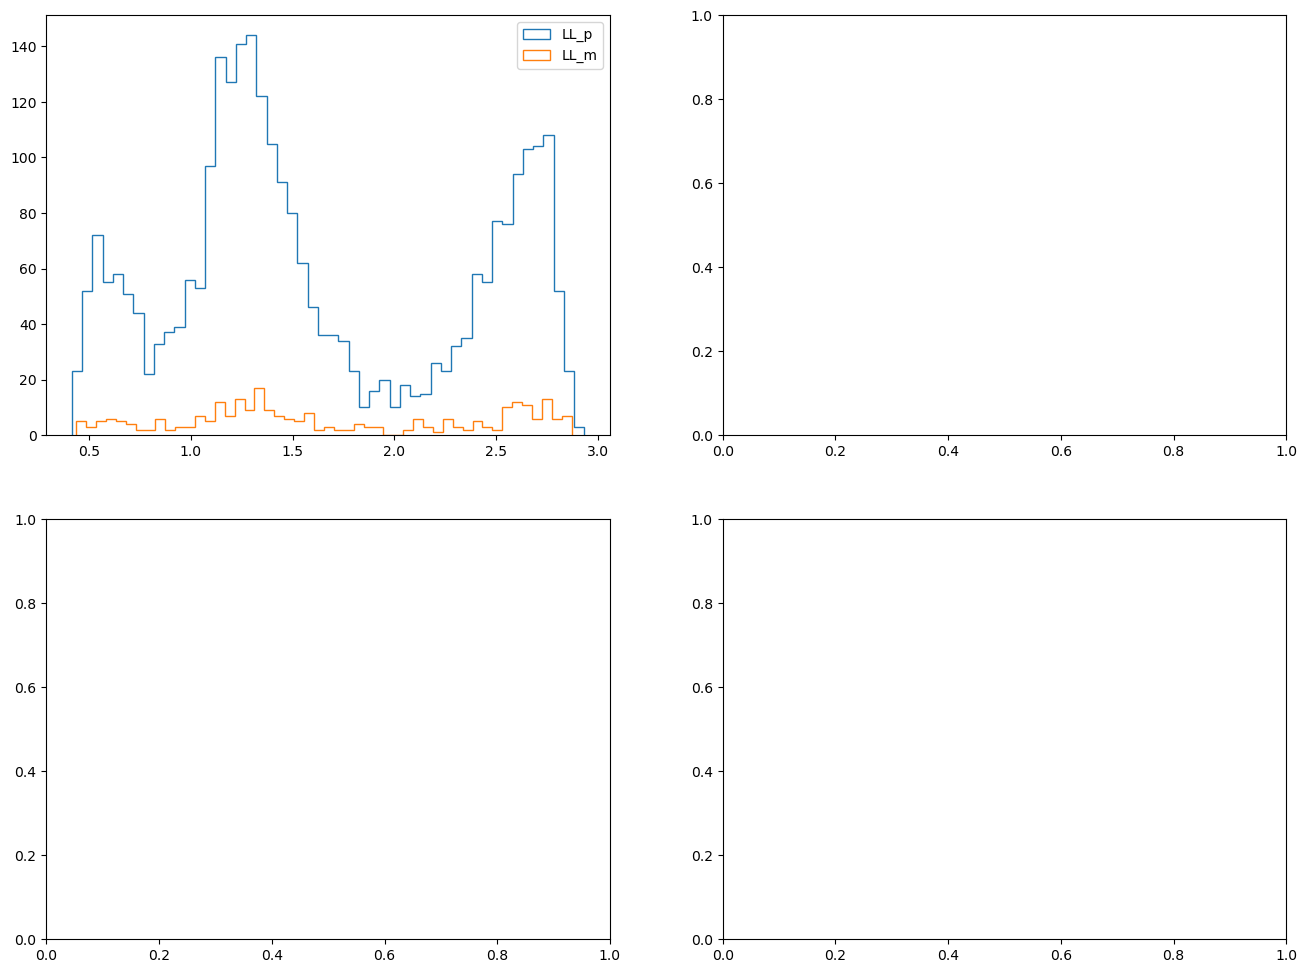

In [7]:
fit, ax = plt.subplots(2, 2, figsize=(8*2, 6*2))
ax = ax.flatten()
ax[0].hist(s12_data['b2dk_DD_p'].flatten(), bins=50, histtype='step', label='LL_p')
ax[0].hist(s12_data_new['b2dk_DD_m'].flatten(), bins=50, histtype='step', label='LL_m')
ax[0].legend()


In [8]:
index=1
from importlib.machinery import SourceFileLoader

In [9]:
def get_mass(p1,p2):
    return ((p1[:,0]+p2[:,0])**2 - (p1[:,1]+p2[:,1])**2 - (p1[:,2]+p2[:,2])**2 - (p1[:,3]+p2[:,3])**2)


def get_p4(decay="b2dpi", cut='', index=index):

    file_name = ''
    branch_names = []
    if cut == 'int':
        file_name = f'/software/pc24403/PCBPGGSZ/Int/weighted_{decay}.root:DalitzEventList'
        branch_names = ["_1_K0S0_E", "_1_K0S0_Px", "_1_K0S0_Py", "_1_K0S0_Pz",
                         "_2_pi#_E", "_2_pi#_Px", "_2_pi#_Py", "_2_pi#_Pz",
                         "_3_pi~_E", "_3_pi~_Px", "_3_pi~_Py", "_3_pi~_Pz"]
    
    elif decay.split('_')[0] == 'b2dk' or decay.split('_')[0] == 'b2dpi':
        branch_names = ["_1_K0S0_E", "_1_K0S0_Px", "_1_K0S0_Py", "_1_K0S0_Pz",
                         "_2_pi#_E", "_2_pi#_Px", "_2_pi#_Py", "_2_pi#_Pz",
                         "_3_pi~_E", "_3_pi~_Px", "_3_pi~_Py", "_3_pi~_Pz"]
        if cut == 'p':
            file_name = f'/software/pc24403/PCBPGGSZ/outputs/toy/1x_test/phsp/{decay}_comb_{index}.root:DalitzEventList'
#            file_name = f'/software/pc24403/PCBPGGSZ/outputs/toy/swap/{decay}_{comp}_{index}.root:Bplus_DalitzEventList'

        else:
            file_name = f'/software/pc24403/PCBPGGSZ/outputs/toy/1x_test/phsp/{decay}_comb_{index}.root:DalitzEventList'
#            file_name = f'/software/pc24403/PCBPGGSZ/outputs/toy/swap/{decay}_{comp}_{index}.root:Bminus_DalitzEventList'

    tree = up.open(file_name)
  # Load the branches as arrays
    charge = '(Bac_ID>0)'
    if cut == 'm':
        charge = '(Bac_ID<0)'
       
    array = tree.arrays(branch_names, charge)
    _p1 = np.asarray([array["_1_K0S0_E"], array["_1_K0S0_Px"], array["_1_K0S0_Py"], array["_1_K0S0_Pz"]])
    _p2 = np.asarray([array["_2_pi#_E"], array["_2_pi#_Px"], array["_2_pi#_Py"], array["_2_pi#_Pz"]])
    _p3 = np.asarray([array["_3_pi~_E"], array["_3_pi~_Px"], array["_3_pi~_Py"], array["_3_pi~_Pz"]])
    
    # convert 4*1000 into a vectot<double>
    p1 = np.transpose(_p1)
    p2 = np.transpose(_p2)
    p3 = np.transpose(_p3)

    p1bar = np.hstack((p1[:, :1], np.negative(p1[:, 1:])))
    p2bar = np.hstack((p2[:, :1], np.negative(p2[:, 1:])))
    p3bar = np.hstack((p3[:, :1], np.negative(p3[:, 1:])))



    return p1, p2, p3, p1bar, p2bar, p3bar

def load_int_amp(args):
    p1, p2, p3 = args

    return Kspipi.AMP(p1.tolist(), p2.tolist(), p3.tolist())

def getAmp(decay='b2dpi', cut='int', index=index):

    start_time = time.time()
    p1, p2, p3, p1bar, p2bar, p3bar = get_p4(decay=decay, cut=cut, index=index)
    amplitude = []
    amplitudeBar = []

    p1_np = np.array(p1)
    p2_np = np.array(p2)
    p3_np = np.array(p3)
    p1bar_np = np.array(p1bar)
    p2bar_np = np.array(p2bar)
    p3bar_np = np.array(p3bar)

    data = [(p1_np[i], p2_np[i], p3_np[i]) for i in range(len(p1_np))]
    with Pool(processes=multiprocessing.cpu_count()) as pool:
        amplitude.append(pool.map(load_int_amp, data))
    data_bar = [(p1bar_np[i], p3bar_np[i], p2bar_np[i]) for i in range(len(p1bar_np))]
    with Pool(processes=multiprocessing.cpu_count()) as pool:
        amplitudeBar.append(pool.map(load_int_amp, data_bar))
    
    end_time = time.time()
    print(f'Amplitude for {decay} loaded in {end_time-start_time} seconds')
    amplitude = np.array(amplitude)
    amplitudeBar = np.array(amplitudeBar)

    return amplitude, amplitudeBar
    
def get_p4_v2(decay="b2dpi", cut='', index=index, comp='sig'):

    file_name = ''
    branch_names = []
    if cut == 'int':
        file_name = f'/software/pc24403/PCBPGGSZ/Int/weighted_{decay}.root:DalitzEventList'
        branch_names = ["_1_K0S0_E", "_1_K0S0_Px", "_1_K0S0_Py", "_1_K0S0_Pz",
                         "_2_pi#_E", "_2_pi#_Px", "_2_pi#_Py", "_2_pi#_Pz",
                         "_3_pi~_E", "_3_pi~_Px", "_3_pi~_Py", "_3_pi~_Pz"]
    
    elif decay.split('_')[0] == 'b2dk' or decay.split('_')[0] == 'b2dpi':
        branch_names = ["_1_K0S0_E", "_1_K0S0_Px", "_1_K0S0_Py", "_1_K0S0_Pz",
                         "_2_pi#_E", "_2_pi#_Px", "_2_pi#_Py", "_2_pi#_Pz",
                         "_3_pi~_E", "_3_pi~_Px", "_3_pi~_Py", "_3_pi~_Pz", "B_M"]
        if cut == 'p':
            file_name = f'/software/pc24403/PCBPGGSZ/outputs/toy/1x_test/phsp/{decay}_comb_{index}.root:DalitzEventList'
#            file_name = f'/software/pc24403/PCBPGGSZ/outputs/toy/swap/{decay}_{comp}_{index}.root:Bplus_DalitzEventList'

        else:
            file_name = f'/software/pc24403/PCBPGGSZ/outputs/toy/1x_test/phsp/{decay}_comb_{index}.root:DalitzEventList'
#            file_name = f'/software/pc24403/PCBPGGSZ/outputs/toy/swap/{decay}_{comp}_{index}.root:Bminus_DalitzEventList'

    tree = up.open(file_name)
  # Load the branches as arrays
    charge = '(Bac_ID>0)'
    if cut == 'm':
        charge = '(Bac_ID<0)'
    
    array = tree.arrays(branch_names, charge)
       

    _p1 = np.asarray([array["_1_K0S0_E"], array["_1_K0S0_Px"], array["_1_K0S0_Py"], array["_1_K0S0_Pz"]])
    _p2 = np.asarray([array["_2_pi#_E"], array["_2_pi#_Px"], array["_2_pi#_Py"], array["_2_pi#_Pz"]])
    _p3 = np.asarray([array["_3_pi~_E"], array["_3_pi~_Px"], array["_3_pi~_Py"], array["_3_pi~_Pz"]])
    
    # convert 4*1000 into a vectot<double>
    p1 = np.transpose(_p1)
    p2 = np.transpose(_p2)
    p3 = np.transpose(_p3)

    p1bar = np.hstack((p1[:, :1], np.negative(p1[:, 1:])))
    p2bar = np.hstack((p2[:, :1], np.negative(p2[:, 1:])))
    p3bar = np.hstack((p3[:, :1], np.negative(p3[:, 1:])))

    B_M = np.zeros(len(p1))
    if cut != 'int':
        
        B_M = np.asarray([array["B_M"]])


    return p1, p2, p3, p1bar, p2bar, p3bar, B_M


def getMass(decay='b2dpi', cut='int', index=index):

    start_time = time.time()
    p1, p2, p3, p1bar, p2bar, p3bar = get_p4(decay=decay, cut=cut, index=index)
    amplitude = []
    amplitudeBar = []

    p1_np = np.array(p1)
    p2_np = np.array(p2)
    p3_np = np.array(p3)
    p1bar_np = np.array(p1bar)
    p2bar_np = np.array(p2bar)
    p3bar_np = np.array(p3bar)

    s12 = get_mass(p1_np, p2_np)
    s13 = get_mass(p1_np, p3_np)

    return s12, s13

def getMass_v2(decay='b2dpi', cut='int', comp='sig', index=index):

    start_time = time.time()
    p1, p2, p3, p1bar, p2bar, p3bar, B_M = get_p4_v2(decay=decay, cut=cut, comp=comp, index=index)
    amplitude = []
    amplitudeBar = []

    p1_np = np.array(p1)
    p2_np = np.array(p2)
    p3_np = np.array(p3)
    p1bar_np = np.array(p1bar)
    p2bar_np = np.array(p2bar)
    p3bar_np = np.array(p3bar)

    s12 = get_mass(p1_np, p2_np)
    s13 = get_mass(p1_np, p3_np)

    return s12, s13, B_M




config_mass_shape_output = SourceFileLoader('config_mass_shape_output', '/software/pc24403/PCBPGGSZ/outputs/toy/mass_fit/config/lhcb/%s'%(f'config_cpfit_output_{index}.py')).load_module()
#config_mass_shape_output = SourceFileLoader('config_mass_shape_output', '/software/pc24403/PCBPGGSZ/mass_fit/config/%s'%(f'config_CPrange_input_All.py')).load_module()


In [10]:
sys.path.append('/software/pc24403/tfpcbpggsz/func')
sys.path.append('/software/pc24403/tfpcbpggsz/amp_ampgen_test')
sys.path.append('/software/pc24403/tfpcbpggsz/core')
from amp import *
from core_test_mine import *
from tfmassshape import *

varDict = config_mass_shape_output.getconfig()
pdfs_mc = {}
s12_mc = {}
s13_mc = {}
Bu_M_mc = {}
for decay in ['b2dk_DD']:
    for charge in ['p', 'm']:
        new_decay = decay + '_'+ charge
        print('--- INFO: Preparing pdfs for %s...'%new_decay)
        s12_mc[new_decay], s13_mc[new_decay] = getMass(new_decay, 'int')
        Bu_M_mc[new_decay] = np.linspace(5150, 5800, s12_mc[new_decay].shape[0])
        pdfs_mc[new_decay] = preparePdf_data(Bu_M_mc[new_decay], varDict, decay)


mass_pdfs={}
comps = ['sig', 'misid', 'comb', 'low', 'low_misID', 'comb']
for decay in ['b2dk_DD']:
    for charge in ['p', 'm']:
        new_decay = decay + '_'+ charge
        mass_pdfs[new_decay] = {}
        for comp in comps:
            if decay.split('_')[0] == 'b2dpi' and (comp == 'comb' or comp == 'low_misID'): continue
            mass_pdfs[new_decay][comp] = pdfs_mc[new_decay][comp](Bu_M_mc[new_decay])
time2 = time.time()
        
print('INFO: mass Function loaded...')

print('INFO: Loading amplitudes...')

mc_path = '/shared/scratch/pc24403/amp_ampgen'
amp_dk_dd_p = np.load(mc_path + '/Int_b2dk_DD_p_amp.npy')
ampbar_dk_dd_p = np.load(mc_path + '/Int_b2dk_DD_p_ampbar.npy')
amp_dk_dd_m = np.load(mc_path + '/Int_b2dk_DD_m_amp.npy')
ampbar_dk_dd_m = np.load(mc_path + '/Int_b2dk_DD_m_ampbar.npy')


D0ToKSpipi2018 (Apr 30 2024) ==> Initialization !
--- INFO: Preparing pdfs for b2dk_DD_p...
--- Constructing signal pdfs...
--- Constructing misID pdfs...
--- Constructing low-mass pdfs...
--- Constructing comb pdfs...
--- INFO: Writing to file...
--- INFO: Preparing pdfs for b2dk_DD_m...
--- Constructing signal pdfs...
--- Constructing misID pdfs...
--- Constructing low-mass pdfs...
--- Constructing comb pdfs...
--- INFO: Writing to file...
INFO: mass Function loaded...
INFO: Loading amplitudes...


In [15]:
mass_pdfs['b2dk_DD_m']['comb']

<tf.Tensor: shape=(803192,), dtype=float64, numpy=
array([0.00421839, 0.00421837, 0.00421836, ..., 0.00033883, 0.00033883,
       0.00033883])>

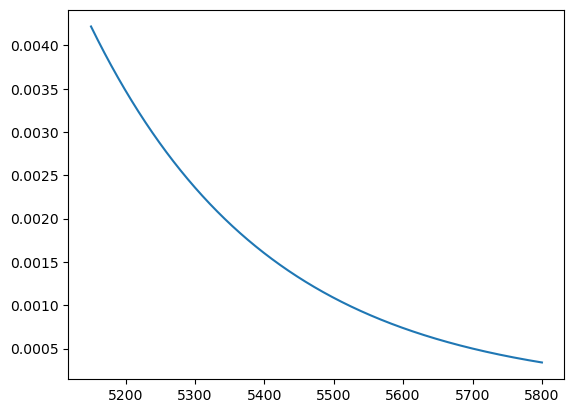

In [17]:
plt.plot(Bu_M_mc['b2dk_DD_m'], mass_pdfs['b2dk_DD_m']['comb'])

In [11]:
amp_dpi_dd_p = np.load(mc_path + '/Int_b2dpi_DD_p_amp.npy')
ampbar_dpi_dd_p = np.load(mc_path + '/Int_b2dpi_DD_p_ampbar.npy')
amp_dpi_dd_m = np.load(mc_path + '/Int_b2dpi_DD_m_amp.npy')
ampbar_dpi_dd_m = np.load(mc_path + '/Int_b2dpi_DD_m_ampbar.npy')

In [12]:
def prob_dk_dd(x, Bsign=1):

    decay = 'b2dk_DD'
    fracDD = 0.53*0.

    nsig = x[6]*0.5
    nmisid = varDict['n_misid_DK_KsPiPi_DD']*0.5
    ncomb = x[7]*0.5
    nlow = x[8]*0.5
    frac_low_misID = varDict['n_low_misID_DK_KsPiPi_DD']/varDict['n_low_DPi_KsPiPi_DD']
    nlow_misID = varDict['n_low_misID_DK_KsPiPi_DD']*0.5
    ncomb = varDict['n_comb_DK_KsPiPi_DD']*0.5



    normalisationCrossTerms_p = totalAmplitudeSquared_Integrated_crossTerm(amp_dk_dd_p, ampbar_dk_dd_p)
    normalisationCrossTerms_m = totalAmplitudeSquared_Integrated_crossTerm(amp_dk_dd_m, ampbar_dk_dd_m)
    misid_normalisationCrossTerms_p = totalAmplitudeSquared_Integrated_crossTerm(amp_dpi_dd_p, ampbar_dpi_dd_p)
    misid_normalisationCrossTerms_m = totalAmplitudeSquared_Integrated_crossTerm(amp_dpi_dd_m, ampbar_dpi_dd_m)

    normA_p = tf.math.reduce_mean(tf.math.abs(amp_dk_dd_p)**2)
    normAbar_p = tf.math.reduce_mean(tf.math.abs(ampbar_dk_dd_p)**2)
    normA_m = tf.math.reduce_mean(tf.math.abs(amp_dk_dd_m)**2)
    normAbar_m = tf.math.reduce_mean(tf.math.abs(ampbar_dk_dd_m)**2)

    misid_normA_p = tf.math.reduce_mean(tf.math.abs(amp_dpi_dd_p)**2)
    misid_normAbar_p = tf.math.reduce_mean(tf.math.abs(ampbar_dpi_dd_p)**2)
    misid_normA_m = tf.math.reduce_mean(tf.math.abs(amp_dpi_dd_m)**2)
    misid_normAbar_m = tf.math.reduce_mean(tf.math.abs(ampbar_dpi_dd_m)**2)

    sig_prob_p = nsig * mass_pdfs[decay+'_p']['sig'] * prod_totalAmplitudeSquared_XY(1, amp_dk_dd_p, ampbar_dk_dd_p, x, mass_pdfs[decay+'_p']['sig'], mass_pdfs[decay+'_m']['sig'], Bu_M[decay+'_p'], Bu_M[decay+'_m'])
    sig_prob_m = nsig * mass_pdfs[decay+'_m']['sig'] * prod_totalAmplitudeSquared_XY(-1, amp_dk_dd_m, ampbar_dk_dd_m, x, mass_pdfs[decay+'_p']['sig'], mass_pdfs[decay+'_m']['sig'], Bu_M[decay+'_p'], Bu_M[decay+'_m'])
    misid_prob_p = nmisid * mass_pdfs[decay+'_p']['misid'] * prod_totalAmplitudeSquared_DPi_XY(1, amp_dk_dd_p, ampbar_dk_dd_p, x, mass_pdfs[decay+'_p']['misid'], mass_pdfs[decay+'_m']['misid'], Bu_M[decay+'_p'], Bu_M[decay+'_m'])
    misid_prob_m = nmisid * mass_pdfs[decay+'_m']['misid'] * prod_totalAmplitudeSquared_DPi_XY(-1, amp_dk_dd_m, ampbar_dk_dd_m, x, mass_pdfs[decay+'_p']['misid'], mass_pdfs[decay+'_m']['misid'], Bu_M[decay+'_p'], Bu_M[decay+'_m'])
    comb_prob_p = ncomb * mass_pdfs[decay+'_p']['comb'] * prod_comb(amp_dk_dd_p, ampbar_dk_dd_p,  misid_normA_m, misid_normAbar_p, fracDD=fracDD)
    comb_prob_m = ncomb * mass_pdfs[decay+'_m']['comb'] * prod_comb(amp_dk_dd_m, ampbar_dk_dd_m,  misid_normA_m, misid_normAbar_p, fracDD=fracDD)
    low_prob_p = nlow * mass_pdfs[decay+'_p']['low'] * prod_low(1, amp_dk_dd_p, ampbar_dk_dd_p, x, mass_pdfs[decay+'_p'], Bu_M[decay+'_p'], type='low')
    low_prob_m = nlow * mass_pdfs[decay+'_m']['low'] * prod_low(-1, amp_dk_dd_m, ampbar_dk_dd_m, x, mass_pdfs[decay+'_m'], Bu_M[decay+'_m'], type='low')
    low_misID_prob_p =  nlow_misID * mass_pdfs[decay+'_p']['low_misID'] * prod_low(1, amp_dk_dd_p, ampbar_dk_dd_p, x, mass_pdfs[decay+'_p'], Bu_M[decay+'_p'], type='low_misID')
    low_misID_prob_m =  nlow_misID * mass_pdfs[decay+'_m']['low_misID'] * prod_low(-1, amp_dk_dd_m, ampbar_dk_dd_m, x, mass_pdfs[decay+'_m'], Bu_M[decay+'_m'], type='low_misID')
    comb_prob_p = ncomb * mass_pdfs[decay+'_p']['comb'] * prod_low(1, amp_dk_dd_p, ampbar_dk_dd_p, x, mass_pdfs[decay+'_p'], Bu_M[decay+'_p'], type='comb')
    comb_prob_m = ncomb * mass_pdfs[decay+'_m']['comb'] * prod_low(-1, amp_dk_dd_m, ampbar_dk_dd_m, x, mass_pdfs[decay+'_m'], Bu_M[decay+'_m'], type='comb')



    total_yield = 1#(nsig + nmisid + ncomb + nlow + nlow_misID + ncomb)*2
    
    normalisation_Bplus = totalAmplitudeSquared_Integrated(1, normA_p, normAbar_p, normalisationCrossTerms_p, x)
    normalisation_Bminus = totalAmplitudeSquared_Integrated(-1, normA_m, normAbar_m, normalisationCrossTerms_m, x)
    misid_normalisation_Bplus = totalAmplitudeSquared_DPi_Integrated(1, misid_normA_p, misid_normAbar_p, misid_normalisationCrossTerms_p, x)
    misid_normalisation_Bminus = totalAmplitudeSquared_DPi_Integrated(-1, misid_normA_m, misid_normAbar_m, misid_normalisationCrossTerms_m, x) 



    comb_normalisation_Bplus = tf.cast((misid_normA_m + misid_normAbar_p)*0.5*fracDD + (1-fracDD), tf.float64)
    comb_normalisation_Bminus = tf.cast((misid_normA_m + misid_normAbar_p)*0.5*fracDD + (1-fracDD), tf.float64)
    low_normalisation_Bplus = tf.cast(misid_normAbar_p, tf.float64)
    low_normalisation_Bminus = tf.cast(misid_normA_m, tf.float64)


    prob_p = {}
    prob_m = {}
    prob_p['total'] = (1/total_yield*((sig_prob_p/normalisation_Bplus)+(misid_prob_p/misid_normalisation_Bplus)+(comb_prob_p/comb_normalisation_Bplus)+(low_prob_p/low_normalisation_Bplus)+(low_misID_prob_p/low_normalisation_Bplus)+(comb_prob_p/low_normalisation_Bplus)))
    prob_m['total'] = (1/total_yield*((sig_prob_m/normalisation_Bminus)+(misid_prob_m/misid_normalisation_Bminus)+(comb_prob_m/comb_normalisation_Bminus)+(low_prob_m/low_normalisation_Bminus)+(low_misID_prob_m/low_normalisation_Bminus)+(comb_prob_m/low_normalisation_Bminus)))
    prob_p['sig'] = (1/total_yield*((sig_prob_p/normalisation_Bplus)))
    prob_m['sig'] = (1/total_yield*((sig_prob_m/normalisation_Bminus)))
    prob_p['misid'] = (1/total_yield*((misid_prob_p/misid_normalisation_Bplus)))
    prob_m['misid'] = (1/total_yield*((misid_prob_m/misid_normalisation_Bminus)))
    prob_p['comb'] = (1/total_yield*((comb_prob_p)))
    prob_m['comb'] = (1/total_yield*((comb_prob_m)))
    prob_p['low'] = (1/total_yield*((low_prob_p/low_normalisation_Bplus)))
    prob_m['low'] = (1/total_yield*((low_prob_m/low_normalisation_Bminus)))
    prob_p['low_misID'] = (1/total_yield*((low_misID_prob_p/low_normalisation_Bplus)))
    prob_m['low_misID'] = (1/total_yield*((low_misID_prob_m/low_normalisation_Bminus)))
    prob_p['comb'] = (1/total_yield*((comb_prob_p/low_normalisation_Bplus)))
    prob_m['comb'] = (1/total_yield*((comb_prob_m/low_normalisation_Bminus)))
                            
    if Bsign ==1:
        return prob_p
    else:
        return prob_m


In [13]:
def plotOn(data=[], var=[], decay=decay, weights=[], nbins=100, ax=None, range=[5150, 5800]):

    print(var[decay].shape)
    colors={'sig': 'blue', 'misid': 'yellowgreen', 'comb': 'violet', 'low': 'pink', 'low_misID': 'silver', 'comb': 'green'}
    filled={'sig': False, 'misid': False, 'comb': True, 'low': True, 'low_misID': True, 'comb': True}
    scale_factor = len(data[decay].flatten())/sum(weights['total'].numpy().flatten())
    print(sum(weights['total'].numpy().flatten()))
    bin_edges = np.linspace(range[0], range[1], nbins+1)
    bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])
    # Assuming s1 is sorted and binned accordingly, this is a placeholder for counting entries per bin
    counts, _ = np.histogram(data[decay], bins=bin_edges)
    # Calculate the standard deviation for the error bars
    std_devs = np.sqrt(counts)
    ax.errorbar(bin_centers, counts, yerr=std_devs, fmt='+', color='darkviolet',  label='Toy Data')
    #for key in prob.keys():
    #ax.hist(var[decay], bins=100, histtype='step', weights=weights['sig']*data[decay].shape[1], label='sig')
    #ax.hist([var[decay], var[decay], var[decay], var[decay], var[decay], var[decay]], bins=100, histtype='step', stacked=True, weights=[weights[key]*var[decay].shape[1] for key in weights.keys()], label=[key for key in weights.keys()])
    keys=['comb', 'low', 'misid', 'sig'] 
    if decay.split('_')[0] == 'b2dk':
        keys=['comb', 'low', 'low_misID', 'comb', 'misid', 'sig']
        colors={'sig': 'yellowgreen', 'misid': 'blue', 'comb': 'violet', 'low': 'pink', 'low_misID': 'silver', 'comb': 'green'}

    ax.hist([var[decay] for key in keys], bins=100, histtype='step', stacked=False, weights=[(weights[key].numpy().flatten()*scale_factor) for key in keys], label=[key for key in keys], color=[colors[key] for key in keys])

    sum_weights = np.zeros(weights[keys[0]].numpy().shape)
    for key in keys:
        sum_weights += weights[key]
    ax.hist(var[decay], weights=sum_weights.numpy().flatten()*scale_factor, color='red', label='Total',bins=100, histtype='step')
    ax.legend()

    ax.set_xlabel('$M(B^{\pm})$')

<>:31: SyntaxWarning: invalid escape sequence '\p'
<>:31: SyntaxWarning: invalid escape sequence '\p'
/tmp/ipykernel_1927259/2214372943.py:31: SyntaxWarning: invalid escape sequence '\p'
  ax.set_xlabel('$M(B^{\pm})$')


In [14]:
x = [-0.14, -0.05, 0.074, 0.104, -0.057, -0.03, varDict['n_sig_DK_KsPiPi_DD'], varDict['n_comb_DK_KsPiPi_DD'], varDict['n_low_DK_KsPiPi_DD'],  varDict['n_sig_DPi_KsPiPi_DD'],  varDict['n_comb_DPi_KsPiPi_DD'], varDict['n_low_DPi_KsPiPi_DD'],  varDict['n_sig_DK_KsPiPi_LL'],  varDict['n_comb_DK_KsPiPi_LL'], varDict['n_low_DK_KsPiPi_LL'],  varDict['n_sig_DPi_KsPiPi_LL'], varDict['n_comb_DPi_KsPiPi_LL'], varDict['n_low_DPi_KsPiPi_LL']]
prob = prob_dpi_dd(x, -1)

NameError: name 'prob_dpi_dd' is not defined

(array([0.39010773, 0.7110028 , 0.5639259 , 0.50887037, 0.43257914,
        0.35314188, 0.29179429, 0.28156969, 0.25561495, 0.1148301 ]),
 array([0.40896539, 0.66514988, 0.92133438, 1.17751887, 1.43370337,
        1.68988786, 1.94607236, 2.20225685, 2.45844135, 2.71462585,
        2.97081034]),
 <BarContainer object of 10 artists>)

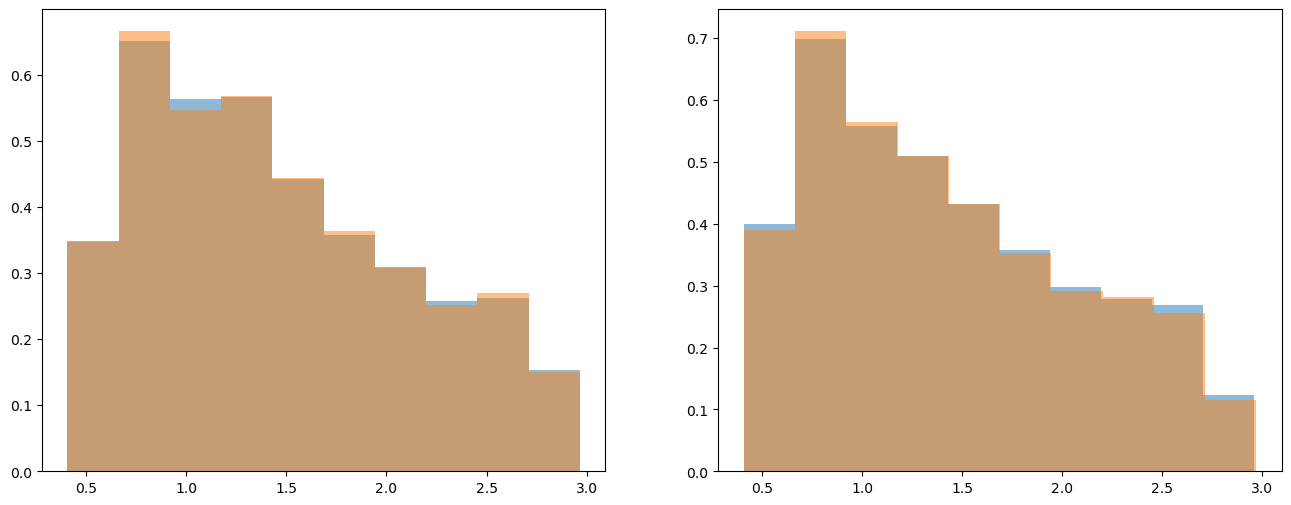

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8*2, 6))
ax1.hist(s12_data['b2dpi_DD_p'].flatten(), bins=10, alpha=0.5, label='b2dk_DD_m', density=True)
ax1.hist(s12_data_new['b2dpi_DD_p'].flatten(), bins=10, alpha=0.5, label='b2dk_DD_p', density=True)
ax2.hist(s13_data['b2dpi_DD_p'].flatten(), bins=10, alpha=0.5, label='b2dk_DD_m', density=True)
ax2.hist(s13_data_new['b2dpi_DD_p'].flatten(), bins=10, alpha=0.5, label='b2dk_DD_p', density=True)


(array([120., 113., 110.,  85.,  93.,  90.,  77.,  71.,  80.,  67.,  69.,
         64.,  52.,  52.,  65.,  60.,  31.,  46.,  41.,  37.,  37.,  38.,
         24.,  33.,  37.,  36.,  25.,  17.,  35.,  21.,  21.,  23.,  14.,
         16.,  17.,  21.,  14.,  20.,  10.,  12.,  13.,  11.,  14.,   6.,
         11.,   5.,  14.,   9.,   5.,   7.]),
 array([5080.0189094 , 5094.36032963, 5108.70174985, 5123.04317008,
        5137.3845903 , 5151.72601053, 5166.06743076, 5180.40885098,
        5194.75027121, 5209.09169143, 5223.43311166, 5237.77453188,
        5252.11595211, 5266.45737233, 5280.79879256, 5295.14021279,
        5309.48163301, 5323.82305324, 5338.16447346, 5352.50589369,
        5366.84731391, 5381.18873414, 5395.53015436, 5409.87157459,
        5424.21299482, 5438.55441504, 5452.89583527, 5467.23725549,
        5481.57867572, 5495.92009594, 5510.26151617, 5524.60293639,
        5538.94435662, 5553.28577685, 5567.62719707, 5581.9686173 ,
        5596.31003752, 5610.65145775, 5624.992

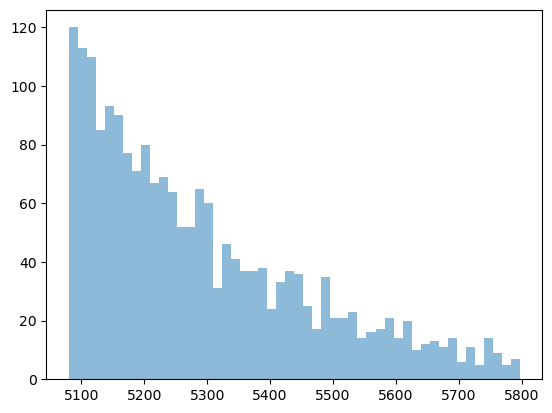

In [ ]:
plt.hist(Bu_M['b2dk_DD_m'].flatten(), bins=50, alpha=0.5, label='b2dk_DD_m')

In [ ]:
import pandas as pd
df = pd.DataFrame({'s12': s12_data['b2dk_DD_m'].flatten(), 's13': s13_data['b2dk_DD_m'].flatten(), 'Bu_M': Bu_M['b2dk_DD_m'].flatten()})

ModuleNotFoundError: No module named 'pandas'

(array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 1., 0., 0.],
        [0., 0., 0., ..., 0., 1., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 1., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 array([0.41964783, 0.4447854 , 0.46992297, 0.49506055, 0.52019812,
        0.54533569, 0.57047327, 0.59561084, 0.62074841, 0.64588599,
        0.67102356, 0.69616113, 0.72129871, 0.74643628, 0.77157385,
        0.79671143, 0.821849  , 0.84698657, 0.87212415, 0.89726172,
        0.92239929, 0.94753687, 0.97267444, 0.99781202, 1.02294959,
        1.04808716, 1.07322474, 1.09836231, 1.12349988, 1.14863746,
        1.17377503, 1.1989126 , 1.22405018, 1.24918775, 1.27432532,
        1.2994629 , 1.32460047, 1.34973804, 1.37487562, 1.40001319,
        1.42515076, 1.45028834, 1.47542591, 1.50056348, 1.52570106,
        1.55083863, 1.5759762 , 1.60111378, 1.62625135, 1.65138892,
        1.6765265 , 1.70166407, 1.72680165, 1.75193922, 1.77707679,
   

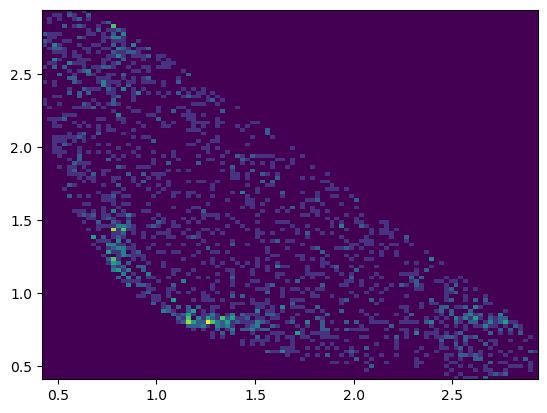

In [ ]:
plt.hist2d(s12_data['b2dk_DD_p'].flatten(), s13_data['b2dk_DD_p'].flatten(), bins=100, cmap='viridis')

(811522,)
15174116.02464715


/tmp/ipykernel_460038/2214372943.py:31: SyntaxWarning: invalid escape sequence '\p'
  ax.set_xlabel('$M(B^{\pm})$')


ValueError: weights should have the same shape as x

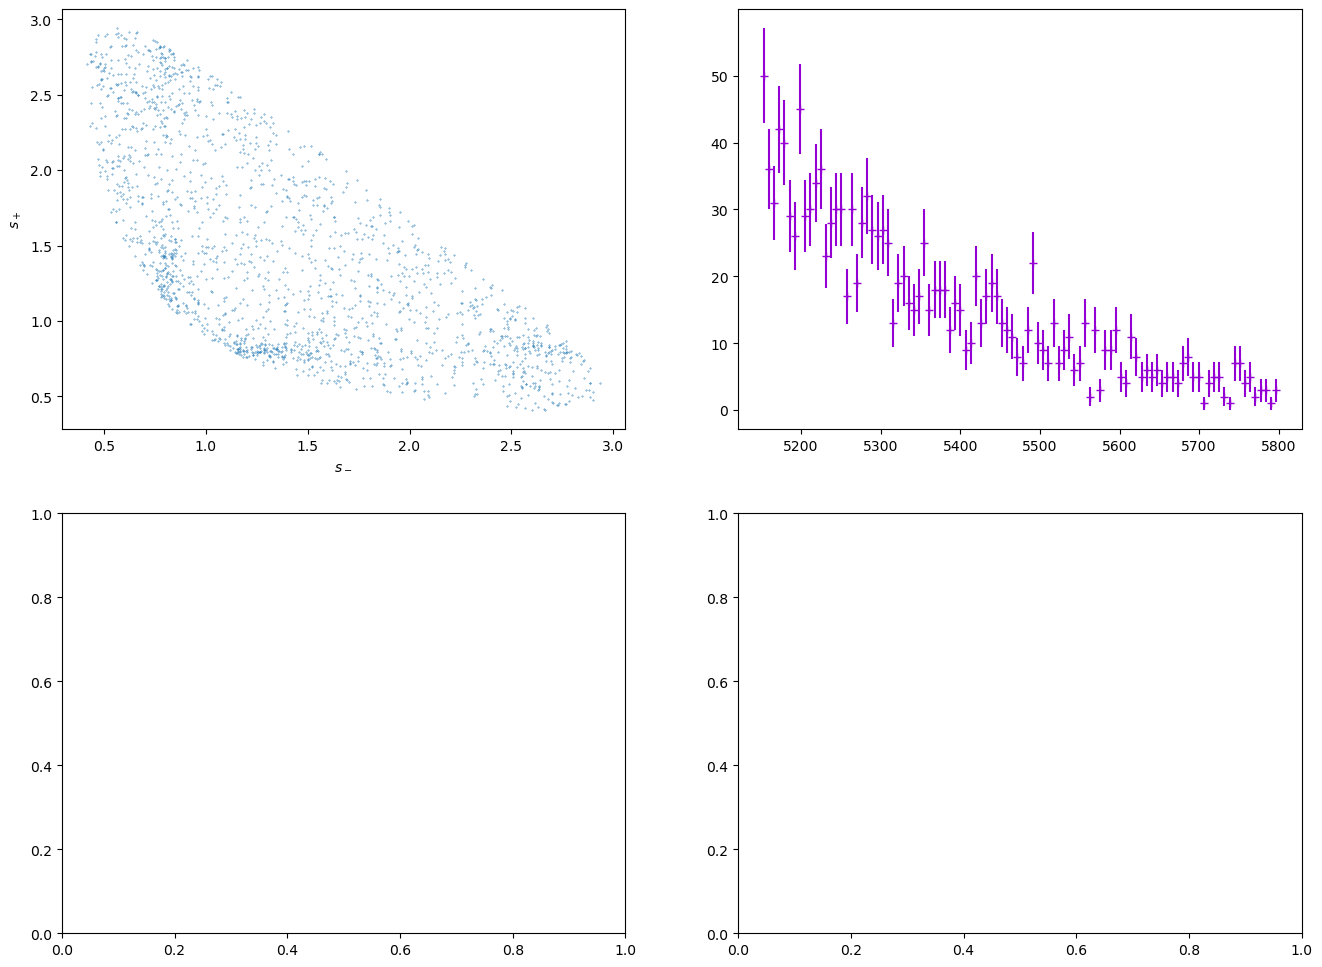

In [ ]:
decay = 'b2dk_DD_p'

fig, ((ax0, ax1), (ax2, ax3)) = plt.subplots(nrows=2, ncols=2, figsize=(8*2, 6*2))
ax0.scatter(s12_data[decay], s13_data[decay],s=0.1)
ax0.set_xlabel('$s_-$')
ax0.set_ylabel('$s_+$')



plotOn(data=Bu_M, var=Bu_M_mc, decay=decay, weights=prob, nbins=100, ax=ax1,range=[5150, 5800])
plotOn(data=s12_data, var=s12_mc, decay=decay, weights=prob, nbins=100, ax=ax2, range=[0.3, 3.2])
plotOn(data=s13_data, var=s13_mc, decay=decay, weights=prob, nbins=100, ax=ax3, range=[0.3, 3.2])




plt.show()

In [ ]:
arr=[1,2,3]
arr_test=arr/np.sum(arr)
arr_test_test=arr_test/np.sum(arr_test)
print(arr_test_test, arr_test)

[0.16666667 0.33333333 0.5       ] [0.16666667 0.33333333 0.5       ]
